In [29]:

import sys
import os
# Path to your src folder
src_path = os.path.abspath("../src")  
sys.path.append(src_path)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from data_loader import load_data

# Load dataset
df = load_data(r"C:\Users\gasha\OneDrive - Wollo University\Desktop\10Academy AIM 8\fnspid\data\raw_analyst_ratings.csv")
df.dropna(subset=['headline', 'date'], inplace=True)
print("Data loaded and cleaned.")
print(df.head())

Data loaded and cleaned.
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2

# Descriptive Statistics:

Basic statistics for headline length:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


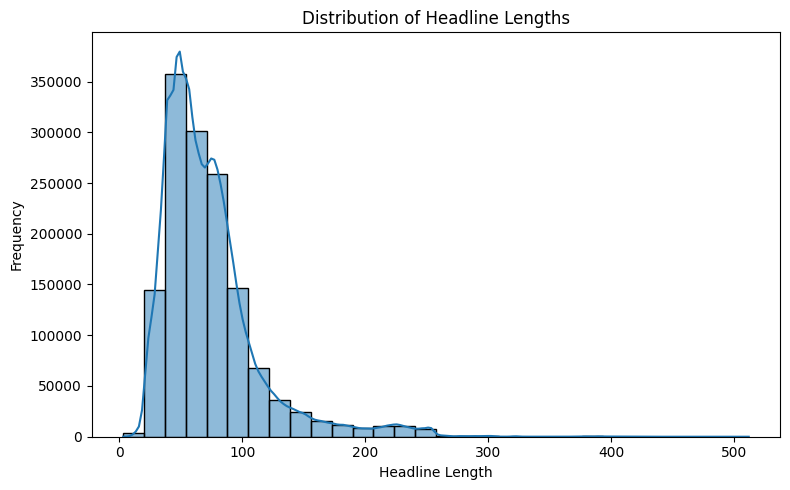

In [19]:
# Headline Length Statistics ---
df['headline_length'] = df['headline'].apply(len)
print("Basic statistics for headline length:")
print(df['headline_length'].describe())

plt.figure(figsize=(8, 5))
sns.histplot(df['headline_length'], bins=30, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Number of articles per publisher:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
Matthew Ely               1
Frank Ochoa               1
Jeremie Capron            1
Marvin Dumont             1
Igor Gonta                1
Name: count, Length: 1034, dtype: int64


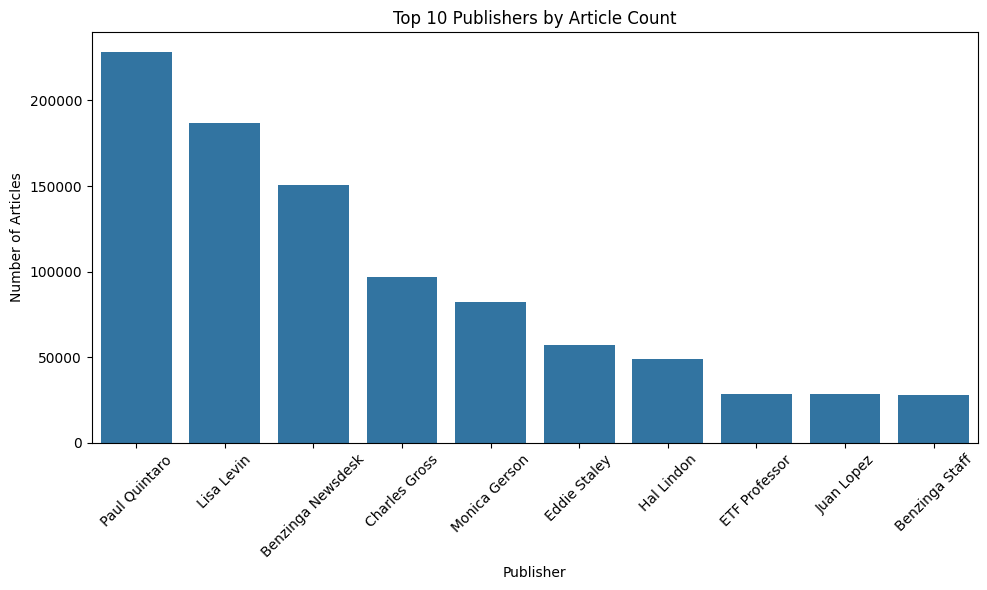

In [20]:
# --- Articles per Publisher ---
publisher_counts = df['publisher'].value_counts()
print("\nNumber of articles per publisher:")
print(publisher_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=publisher_counts.index[:10], y=publisher_counts.values[:10])
plt.title('Top 10 Publishers by Article Count')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

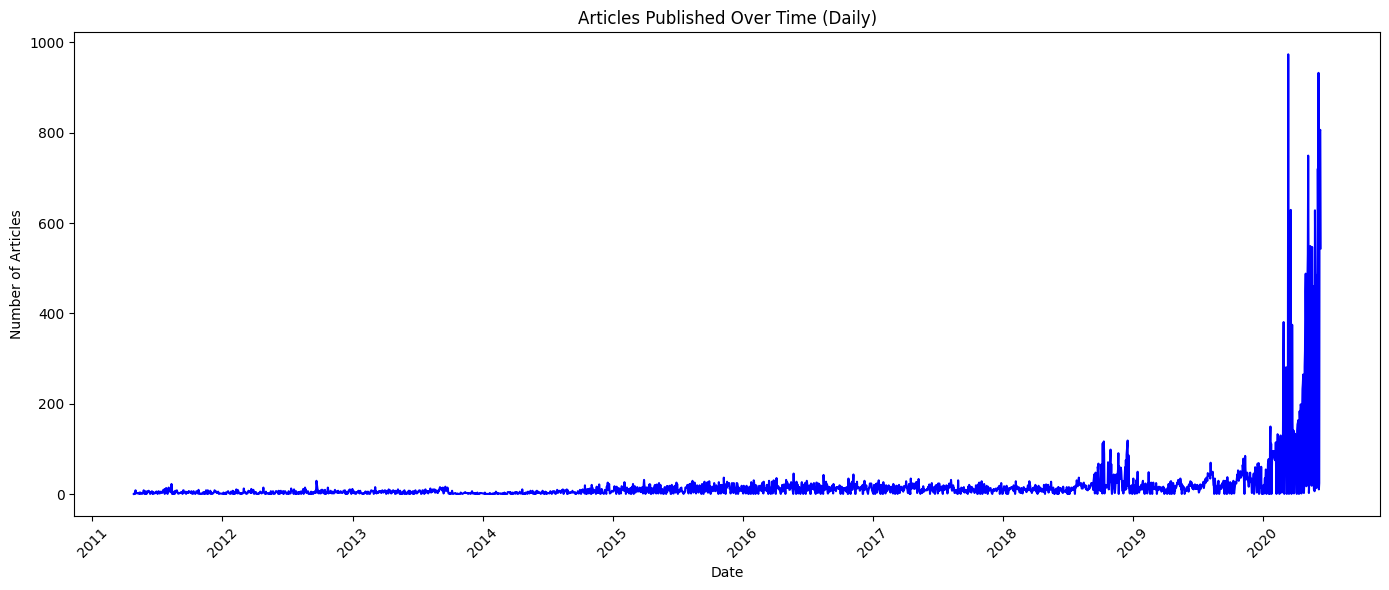

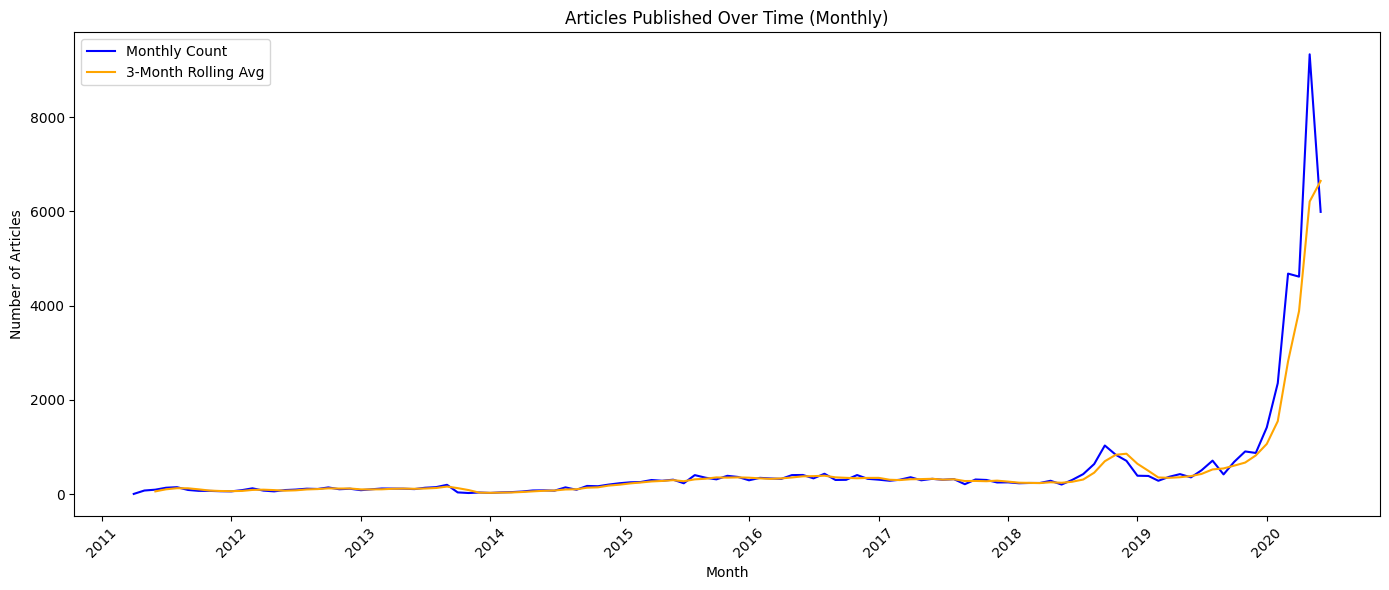

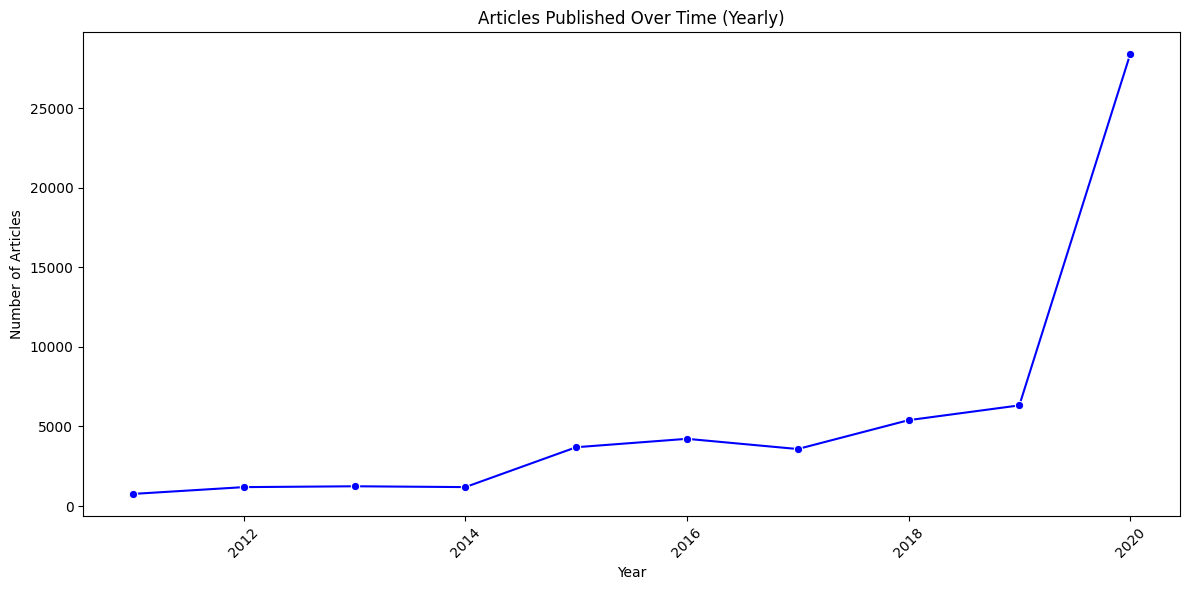

In [35]:
# --- Publication Date Trends ---
# Ensure 'date' column is datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
# Drop rows where date conversion failed
df.dropna(subset=['date'], inplace=True)

# Daily aggregation
daily_counts = df.groupby(df['date'].dt.date).size().reset_index(name='article_count')

plt.figure(figsize=(14, 6))
sns.lineplot(x='date', y='article_count', data=daily_counts, color='blue')
plt.title('Articles Published Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly aggregation
# Remove timezone
df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.tz_localize(None)

df['month'] = df['date'].dt.to_period('M').apply(lambda r: r.start_time)
monthly_counts = df.groupby('month').size().reset_index(name='article_count')
monthly_counts['rolling_avg'] = monthly_counts['article_count'].rolling(window=3).mean()

plt.figure(figsize=(14, 6))
sns.lineplot(x='month', y='article_count', data=monthly_counts, label='Monthly Count', color='blue')
sns.lineplot(x='month', y='rolling_avg', data=monthly_counts, label='3-Month Rolling Avg', color='orange')
plt.title('Articles Published Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Yearly Aggregation
df['year'] = df['date'].dt.year
yearly_counts = df.groupby('year').size().reset_index(name='article_count')

# Plot Yearly Trends 
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='article_count', data=yearly_counts, marker='o', color='blue')
plt.title('Articles Published Over Time (Yearly)')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




# Text Analysis(Topic Modeling):


Top Keywords:
       keyword          score
15      stocks  120048.420657
7       market   83037.704493
14      shares   77559.971297
4     earnings   75181.331827
18          vs   65464.128259
12     reports   64127.172118
17      update   63627.866238
1     benzinga   62142.509181
5          eps   61187.454960
0    announces   55964.729030
19        week   55357.341471
6          est   53595.025097
10          pt   50750.846783
3   downgrades   49541.715976
9        price   48214.325506
2          buy   47506.387748
13       sales   46230.892980
16     trading   43668.171643
8          mid   42797.117879
11      raises   39975.413665


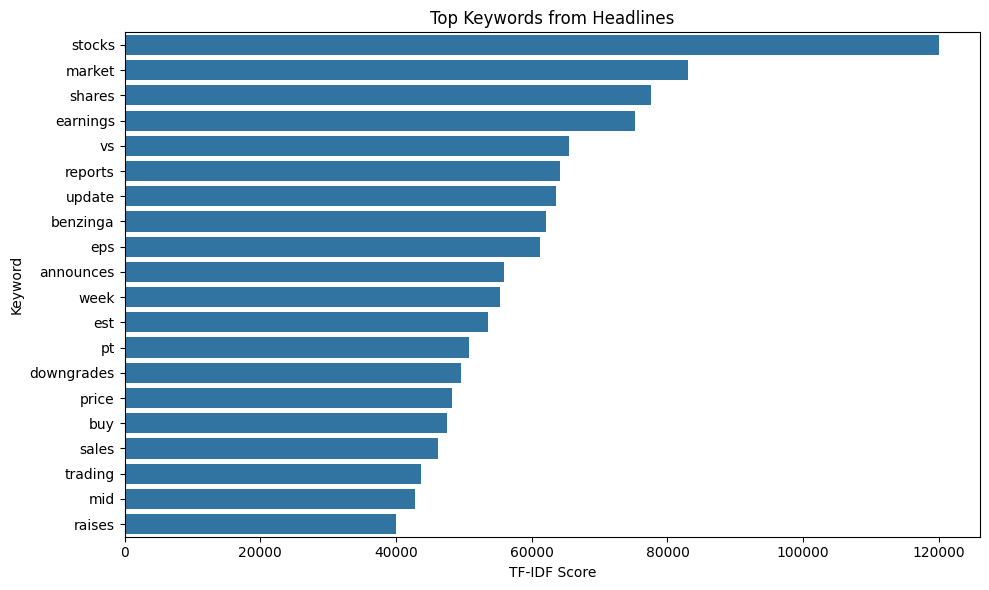

In [32]:

# Topic Modeling and Keyword Extraction
# This notebook identifies common keywords and phrases from financial news headlines using NLP techniques.

# Clean Data 
df.dropna(subset=['headline'], inplace=True)

# Preprocess Headlines 
headlines = df['headline'].str.lower()

# TF-IDF Keyword Extraction 
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(headlines)

# Get top keywords
keywords = vectorizer.get_feature_names_out()
scores = X.sum(axis=0).A1
keyword_df = pd.DataFrame({'keyword': keywords, 'score': scores}).sort_values(by='score', ascending=False)

print("Top Keywords:")
print(keyword_df)

# Visualize Top Keywords 
plt.figure(figsize=(10, 6))
sns.barplot(x='score', y='keyword', data=keyword_df)
plt.title('Top Keywords from Headlines')
plt.xlabel('TF-IDF Score')
plt.ylabel('Keyword')
plt.tight_layout()
plt.show()


# Time Series Analysis

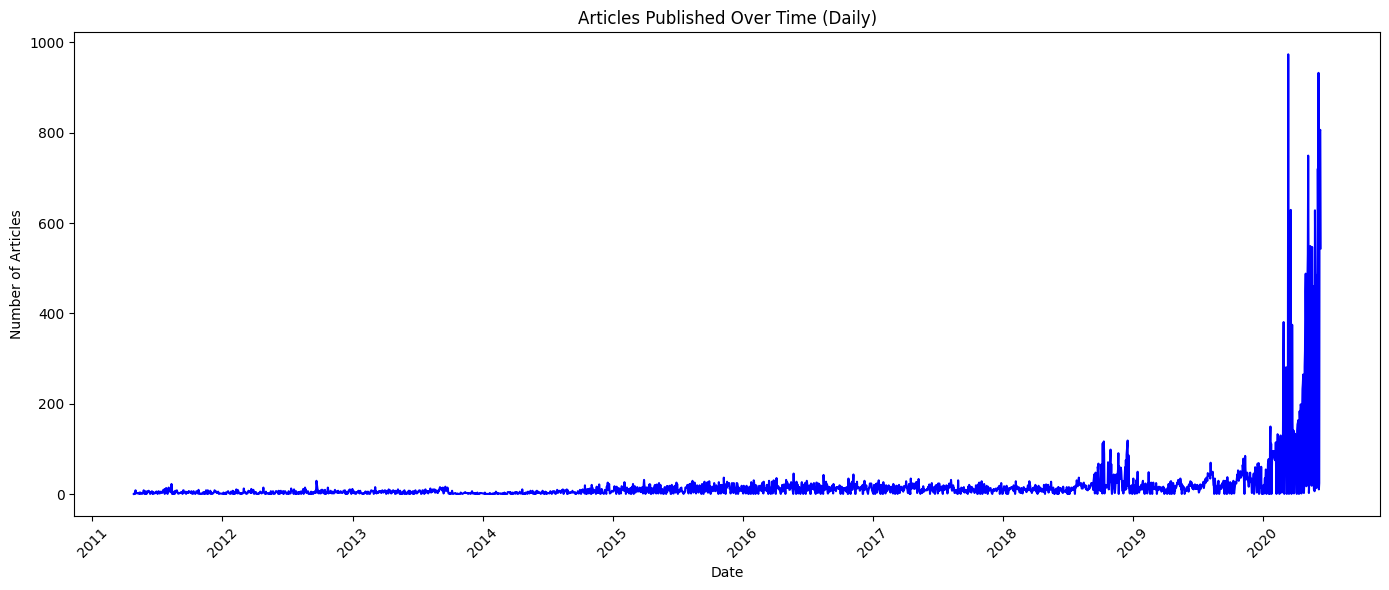

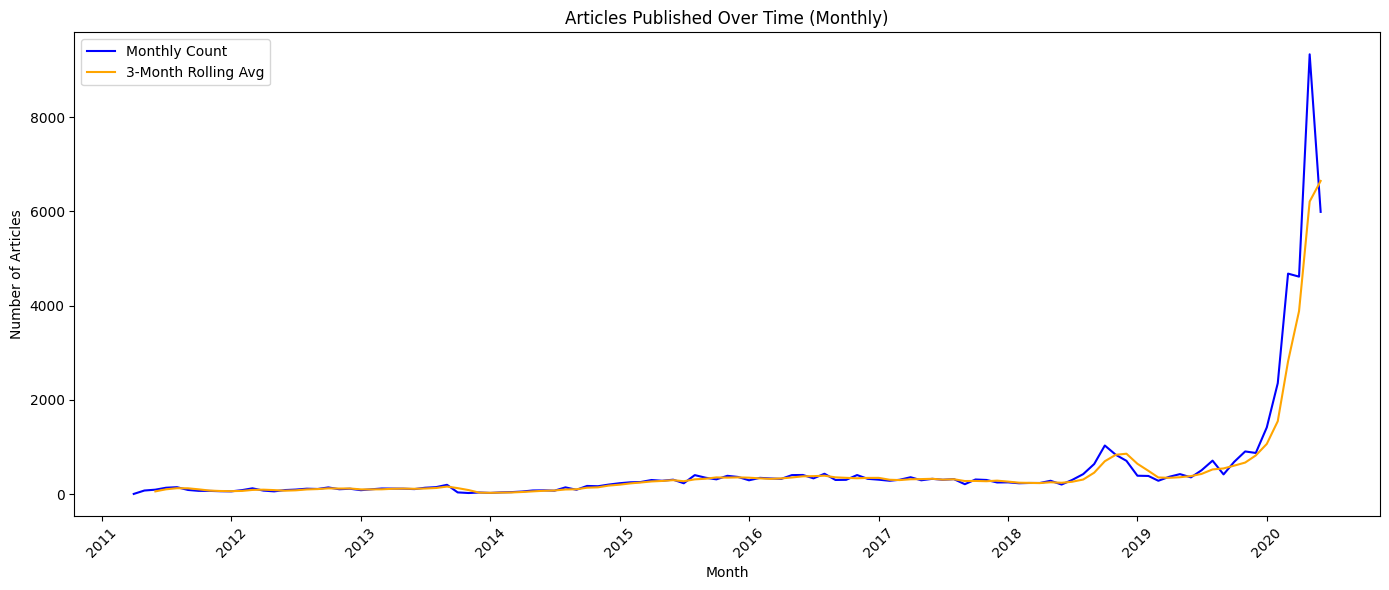

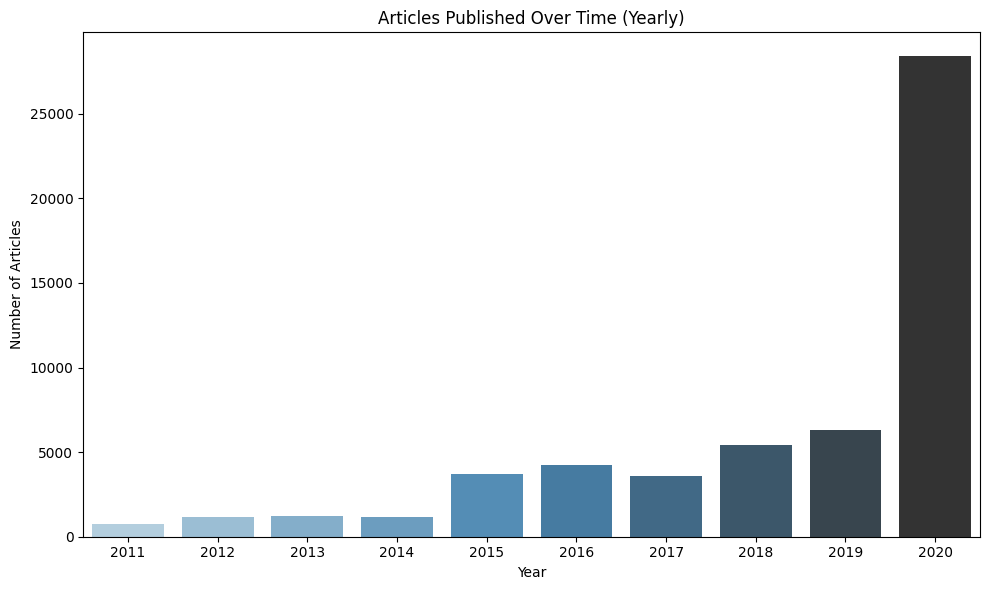

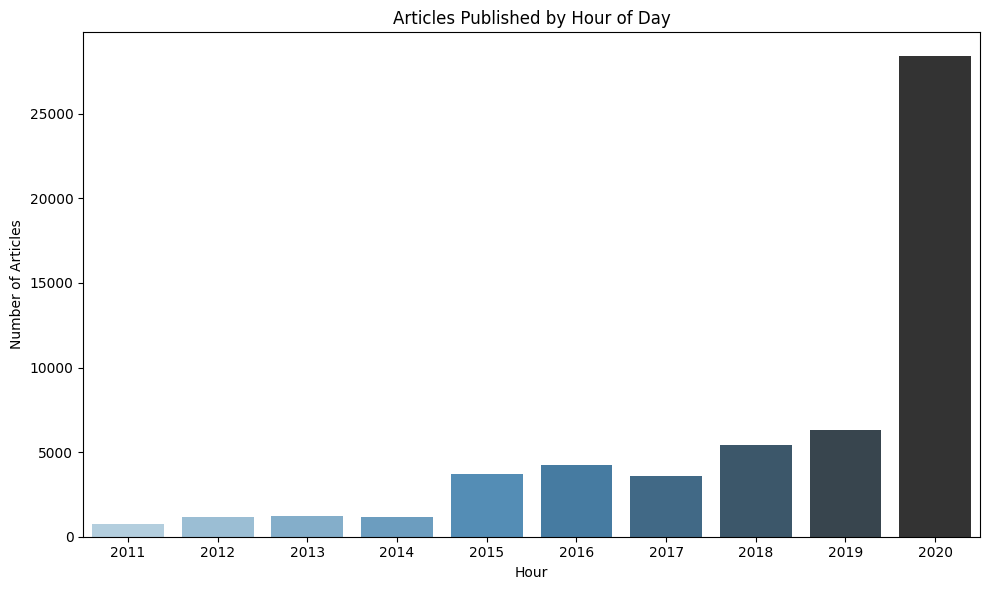

Top spike: 2020-05-01 00:00:00 with 9333 articles


In [55]:
# Remove timezone
#df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.tz_localize(None)
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['date'], inplace=True)

# Extract components
df['day'] = df['date'].dt.date
df['month'] = df['date'].dt.to_period('M').apply(lambda r: r.start_time)
df['year'] = df['date'].dt.year
df['hour'] = df['date'].dt.hour


# Daily Publication Frequency 
daily_counts = df.groupby('day').size().reset_index(name='article_count')

plt.figure(figsize=(14, 6))
sns.lineplot(x='day', y='article_count', data=daily_counts, color='blue')
plt.title('Articles Published Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly Publication Frequency 
monthly_counts = df.groupby('month').size().reset_index(name='article_count')
monthly_counts['rolling_avg'] = monthly_counts['article_count'].rolling(window=3).mean()

plt.figure(figsize=(14, 6))
sns.lineplot(x='month', y='article_count', data=monthly_counts, label='Monthly Count', color='blue')
sns.lineplot(x='month', y='rolling_avg', data=monthly_counts, label='3-Month Rolling Avg', color='orange')
plt.title('Articles Published Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Yearly Publication Frequency 
yearly_counts = df.groupby('year').size().reset_index(name='article_count')

plt.figure(figsize=(10, 6))


sns.barplot(x='year', y='article_count',hue='year', data=yearly_counts,palette='Blues_d',dodge=False,legend=False)
#sns.barplot(x='year', y='article_count', data=yearly_counts, palette='Blues_d')
plt.title('Articles Published Over Time (Yearly)')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

# Publishing Time Analysis 
hourly_counts = df.groupby('hour').size().reset_index(name='article_count')

plt.figure(figsize=(10, 6))

sns.barplot(x='year', y='article_count',hue='year', data=yearly_counts,palette='Blues_d',dodge=False,legend=False)
#sns.barplot(x='year', y='article_count', data=yearly_counts, palette='Blues_d', hue=None)
plt.title('Articles Published by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

# Identify Spikes
top_spike = monthly_counts.loc[monthly_counts['article_count'].idxmax()]
print(f"Top spike: {top_spike['month']} with {top_spike['article_count']} articles")
